In [1]:
import json
import os

import numpy as np
from monai.data import ImageDataset
from monai.metrics import DiceMetric
from monai.transforms import Resize, EnsureChannelFirst, Compose, ScaleIntensity
from monai.utils import first
from torch import sigmoid
from torch.utils.data import DataLoader

from evaluate_util import get_model, plot_model_output
%load_ext autoreload
%autoreload 2

C:\Users\Michael\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
exp_name = "2024_03_14__13_21_53"
exp_path = "experiments/" + exp_name + "/"
with open(exp_path + "config.json", 'r') as file:
    config = json.load(file)

model_config = config["model_config"]

transformer = Compose([EnsureChannelFirst(),
                       ScaleIntensity(),
                       Resize(config["image_size"])])

val_image_path = "data/REFUGE2/Validation/Images/"
val_dm_path = "data/REFUGE2/Validation/Disc_Masks/"

number_of_images = config["batch_size"]

val_data = ImageDataset(image_files=[val_image_path + file for file in os.listdir(val_image_path)[:number_of_images]],
                        transform=transformer,
                        seg_files=[val_dm_path + file for file in os.listdir(val_dm_path)[:number_of_images]],
                        seg_transform=transformer)

val_dataloader = DataLoader(val_data, batch_size=config["batch_size"], num_workers=4, shuffle=True)

print("config of experiment " + exp_name + "\n-----------------------------------------")
for key in config.keys():
    if isinstance(config[key], dict):
        for sub_key in config[key].keys():
            print("\t" + sub_key + ": " + str(config[key][sub_key]))
    else:
        print(key + ": " + str(config[key]))

config of experiment 2024_03_14__13_21_53
-----------------------------------------
	spatial_dims: 2
	in_channels: 3
	out_channels: 3
	channels: [16, 32, 64, 128, 256]
	strides: [2, 2, 2, 2]
	kernel_size: 3
	up_kernel_size: 3
	num_res_units: 3
	activation: PReLU
	include_background: 1
	sigmoid: 1
	softmax: 0
	lambda_dice: 1.0
	lambda_ce: 0.5
	lambda_top: 200
evaluate_after_training: 1
cuda_name: cuda:0
image_size: [512, 512]
batch_size: 8
epochs: 300


In [8]:
model, _ = get_model(exp_path, config)
metric = DiceMetric()

AttributeError: 'str' object has no attribute 'state'

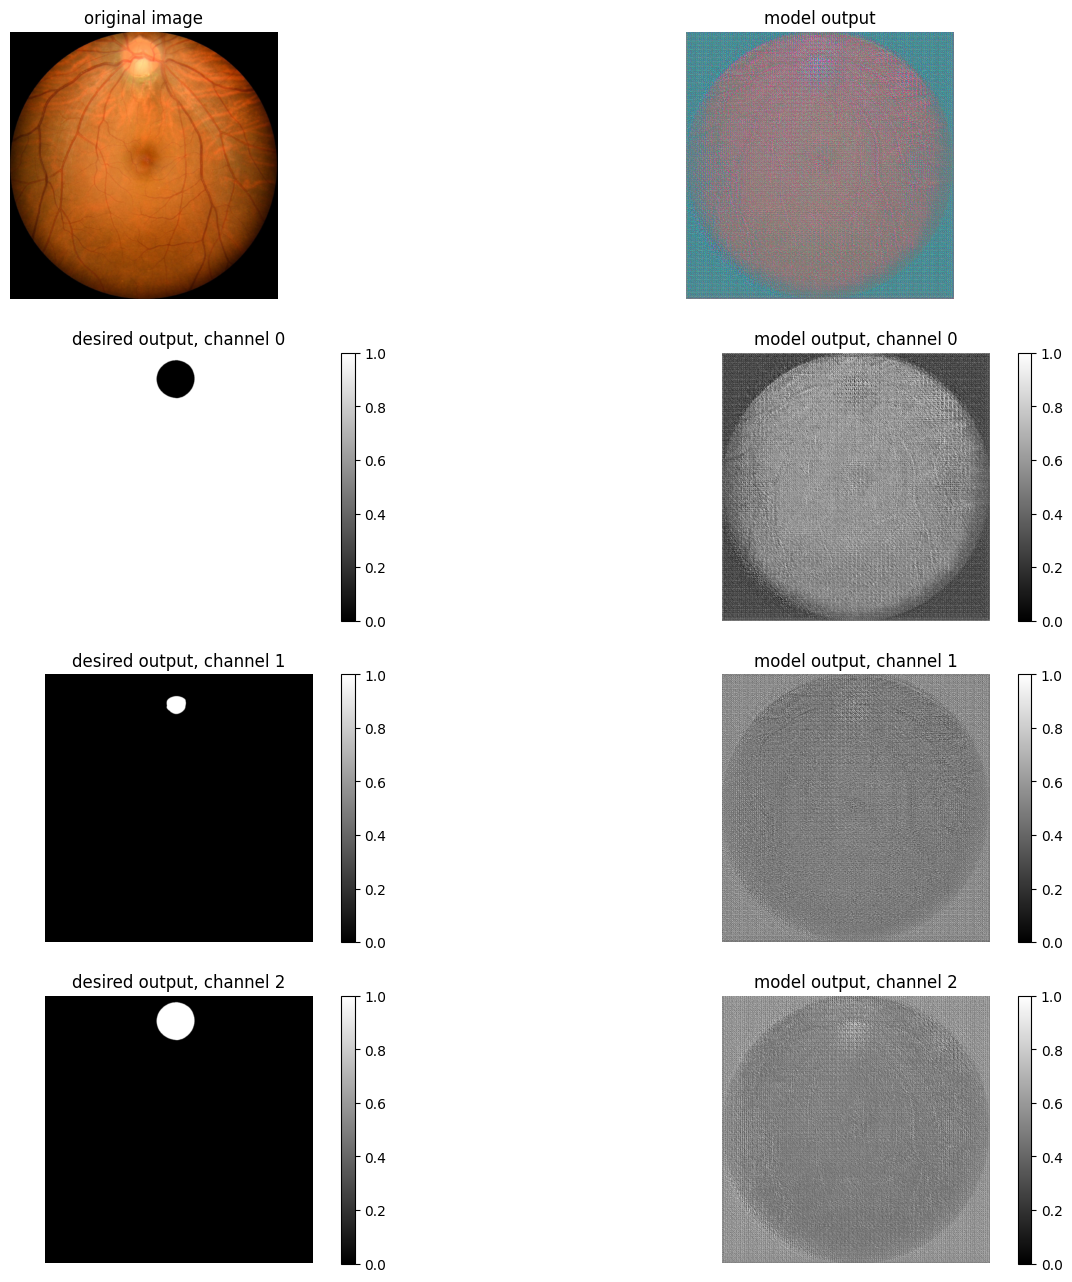

average dice score channel 0: 0.992252, channel 1: 0.007755, channel 2: 0.007755


In [10]:
sum_score = [0, 0, 0]
for j, batch in enumerate(val_dataloader):
    new_images = model(batch[0])
    if j == 0:
        plot_model_output((batch[0], sigmoid(new_images[0].detach()), batch[1]), "output_images/" + exp_name + ".png")
    np.sum(np.array(metric(new_images, batch[1])), axis=0)
    sum_score = [sum_score[i] + np.sum(np.array(metric(new_images, batch[1])), axis=0)[i] for i in
                 range(len(sum_score))]
avg_score = [score / number_of_images for score in sum_score]
print("average dice score channel 0: %f, channel 1: %f, channel 2: %f" % (avg_score[0], avg_score[1], avg_score[2]))